In [1]:
import os
from defillama2 import DefiLlama
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, FuncFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use("fivethirtyeight")

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../'
helper_dir = os.path.join(base_dir, 'helper')
png_dir = os.path.join(base_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

# load helper file
%run {helper_dir}/plot.py

In [3]:
def plot_tvl_apy(df, tvl_col='tvlUsd', apy_col='apy', title=None):
    # plot TVL and APY over time to see their relationships. 
    
    # plot TVL on the left y-axis
    ax1 = df[tvl_col].plot()
    dollar_formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
    ax1.yaxis.set_major_formatter(dollar_formatter)
    for tl in ax1.get_yticklabels():
        tl.set_color('#008FD5')
    ax1.set_ylabel('TVL ($USD)', color='#008FD5')

    # plot APY on the right y-axis
    ax2 = ax1.twinx()
    ax2.plot(df.index, df[apy_col], color='#77AB43')
    ax2.yaxis.set_major_formatter(PercentFormatter(decimals=2))
    for tl in ax2.get_yticklabels():
        tl.set_color('#77AB43')
    ax2.set_ylabel('APY', color='#77AB43')

    plt.title(title)
    plt.tight_layout()

## Get current APY and TVL of the UniV3 WBTC-WETH pools

There are two major UniV3 WBTC-WETH pools:

- [0.3%  fee](https://info.uniswap.org/#/pools/0xcbcdf9626bc03e24f779434178a73a0b4bad62ed)
- [0.05% fee](https://info.uniswap.org/#/pools/0x4585fe77225b41b697c938b018e2ac67ac5a20c0)

In [4]:
obj = DefiLlama()

In [5]:
df = obj.get_pools_yields()

In [6]:
is_true = (
    df.chain.isin(['Ethereum']) &
    df.project.isin(['uniswap-v3']) &
    df.symbol.isin(['WBTC-WETH']) 
)
cols = ['chain', 'project', 'symbol', 'pool', 'tvlUsd', 'apy', 'apyPct7D', 
        'mu', 'sigma', 'count', 'predictedClass', 'predictedProbability']
df.loc[is_true, cols].sort_values('apy', ascending=False)

,chain,project,symbol,pool,tvlUsd,apy,apyPct7D,mu,sigma,count,predictedClass,predictedProbability
102,Ethereum,uniswap-v3,WBTC-WETH,d59a5728-d391-4989-86f6-a94e11e0eb3b,84967107,14.7404,-1.3191,20.5838,0.6896,223,Down,76.0000
5340,Ethereum,uniswap-v3,WBTC-WETH,d12f85a6-6684-4b8e-82bd-f47d3a052ace,132133,13.4812,0.1448,6.5293,0.6390,223,Down,92.0000
43,Ethereum,uniswap-v3,WBTC-WETH,c5599b3a-ea73-4017-a867-72eb971301d1,210709669,13.2632,-4.1265,13.9655,0.4809,223,Stable/Up,54.0000


Observations:

- DefiLlama returns 3 pools. Comparing their TVL with the numbers reported on Uniswap, we conclude the first row is the pool with 0.05% fee and the third row is the pool with 0.3% fee. We'll ignore the 2nd row.
- The 0.05%-fee-pool has a TVL less than half of the 0.3%-fee-pool.
- The 0.05%-fee-pool has a APY slightly more than the 0.3%-fee-pool. For the last 7 days, the APY of the 0.05%-fee-pool dropped by 1.3% whereas the APY of the 0.3%-fee-pool dropped by 4.1%. DefiLlama predicts the APY of the 0.05%-fee-pool will continue to drop and the APY of the 0.3%-fee-pool will remain steady or continue to rise. 
- Historically, over 223 days, the average APY for the 0.05%-fee-pool is 20.58% with a standard deviation of 0.7%, and the average APY for the 0.3%-fee-pool is 13.97% with a standard deviation of 0.48%.

## Get historical APY and TVL of the UniV3 WBTC-WETH pools

In [7]:
pool_005_id = 'd59a5728-d391-4989-86f6-a94e11e0eb3b'
pool_03_id  = 'c5599b3a-ea73-4017-a867-72eb971301d1'

In [8]:
df005 = obj.get_pool_hist_apy(pool_005_id).loc[:,['tvlUsd', 'apy']]
df03  = obj.get_pool_hist_apy(pool_03_id).loc[:,['tvlUsd', 'apy']]

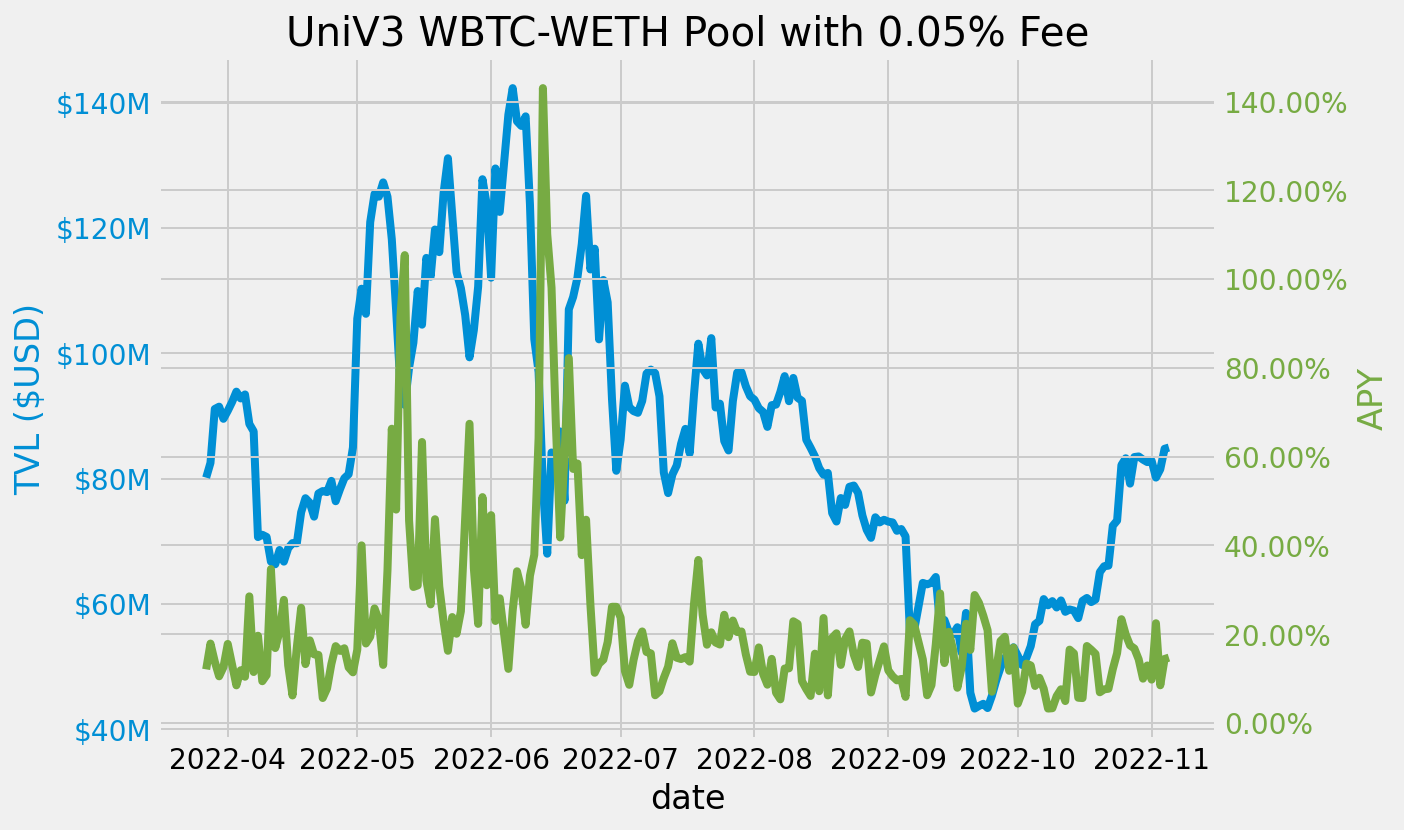

In [9]:
plot_tvl_apy(df005, title='UniV3 WBTC-WETH Pool with 0.05% Fee')
plt.savefig(os.path.join(png_dir, 'UniV3 WBTC-WETH Pool with 0.05% Fee.png'), dpi=300)

The TVL of the 0.05%-fee-pool has been increasing since late September. I suspect the reason was that people saw the 0.05%-fee-pool was generating more fees per unit TVL than the 0.3%-fee-pool and decided to provide liquidity in the 0.05%-fee-pool. The climbing of the TVL hasn't crushed the yield yet. But as DeFiLlama predcited, there is a high probability the TVL will keep going up and the yield will fall. 

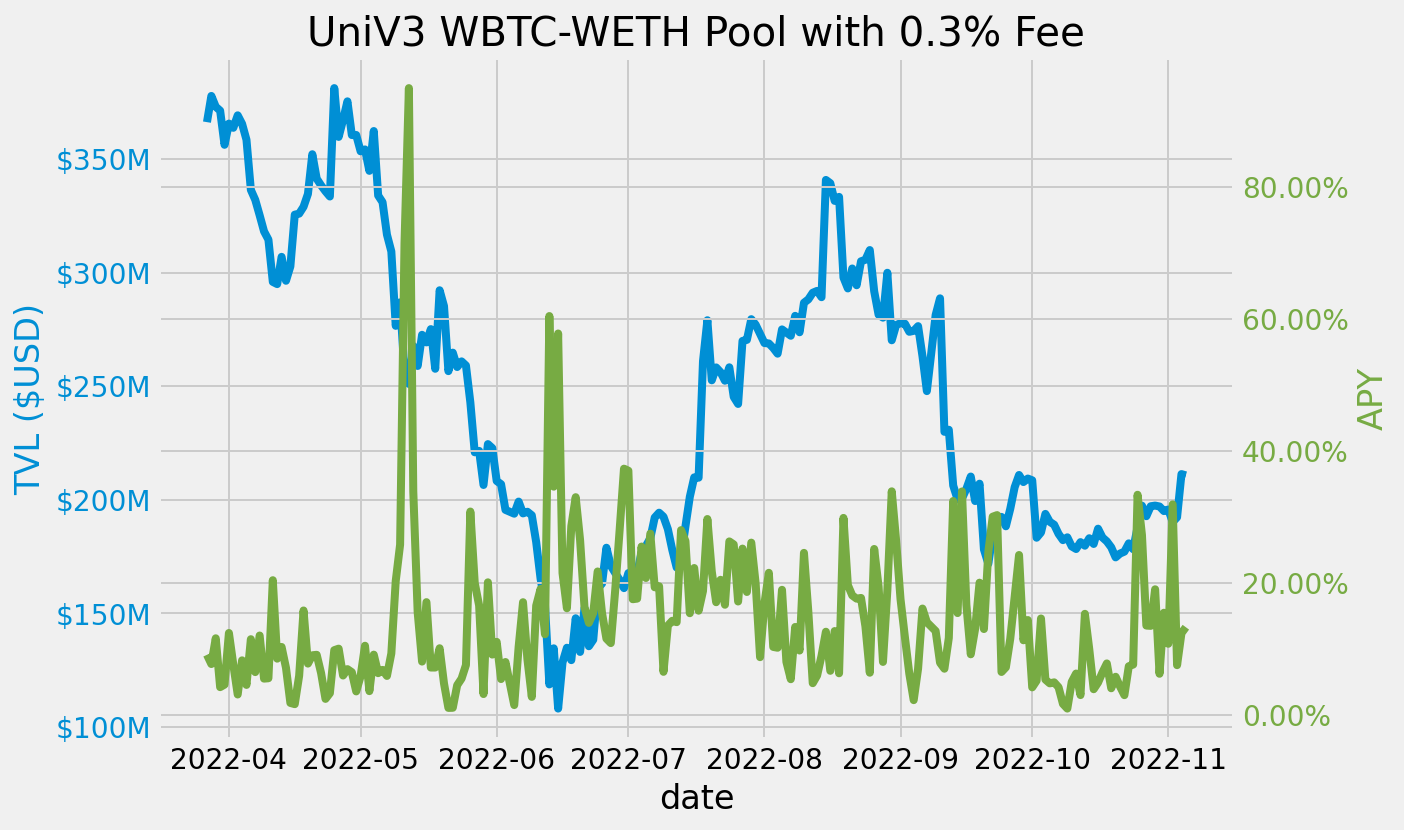

In [10]:
plot_tvl_apy(df03, title='UniV3 WBTC-WETH Pool with 0.3% Fee')
plt.savefig(os.path.join(png_dir, 'UniV3 WBTC-WETH Pool with 0.3% Fee.png'), dpi=300)

The TVL of the 0.3%-fee-pool had a big drop in September. It has stablized with a slight downward trend since the beginning of October.
Its yield has been trending down since mid September but spiked up since end of October. DeFiLlama predicts its yield will NOT drop further. 

In [12]:
# how many days in the past the 0.05%-fee-pool has APY > the 0.3%-fee-pool?
dat = pd.merge(df005, df03, left_index=True, right_index=True)
dat.columns = ['TVL005', 'APY005', 'TVL03', 'APY03']
(dat.APY005 > dat.APY03).sum()

156

In [13]:
(dat.APY005 > dat.APY03).sum() / len(dat)

0.7027027027027027